# Masked Image Modelling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import os.path as osp
from collections import defaultdict
from pathlib import Path
from typing import Callable, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from lightning.pytorch import LightningModule
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import (
    Compose,
    Lambda,
    Normalize,
    RandomCrop,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
)
from torchvision.transforms.functional import InterpolationMode
from transformers import (
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    ViTImageProcessor,
    ViTMAEConfig,
    ViTMAEForPreTraining,
)

from src.mae.module import MAEDatasetConfig, MAEModule, MAEOptimizerConfig, MAEPrepareDataConfig, ViTMAEConfig
from src.modules.transforms import ComplexTransform, SimpleTransform
from src.modules.transforms.color_jitter import ColorJitterPerChannel

In [3]:
for i in range(1, 4):
    if not Path(f"../cpjump{i}/jump/").exists():
        print(f"Mounting cpjump{i}...")
        os.system(f"sshfs bioclust:/projects/cpjump{i}/ ../cpjump{i}")
    else:
        print(f"cpjump{i} already mounted.")

cpjump1 already mounted.
cpjump2 already mounted.
cpjump3 already mounted.


## Dataset

In [4]:
root_dir = "../cpjump1/"
rxrx_dir = osp.join(root_dir, "rxrx1")
jump_dir = osp.join(root_dir, "jump")

print(osp.exists(root_dir), osp.exists(rxrx_dir), osp.exists(jump_dir))

True True True


In [6]:
rx_meta = pd.read_csv(osp.join(rxrx_dir, "metadata.csv"))

In [7]:
rx_meta

,site_id,well_id,cell_type,dataset,experiment,plate,well,site,well_type,sirna,sirna_id
0,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138
1,HEPG2-08_1_B02_2,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,2,negative_control,EMPTY,1138
2,HEPG2-08_1_B03_1,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,1,treatment,s21721,855
3,HEPG2-08_1_B03_2,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,2,treatment,s21721,855
4,HEPG2-08_1_B04_1,HEPG2-08_1_B04,HEPG2,test,HEPG2-08,1,B04,1,treatment,s20894,710
...,...,...,...,...,...,...,...,...,...,...,...
125505,U2OS-03_4_O21_2,U2OS-03_4_O21,U2OS,train,U2OS-03,4,O21,2,treatment,s20367,824
125506,U2OS-03_4_O22_1,U2OS-03_4_O22,U2OS,train,U2OS-03,4,O22,1,treatment,s195079,328
125507,U2OS-03_4_O22_2,U2OS-03_4_O22,U2OS,train,U2OS-03,4,O22,2,treatment,s195079,328
125508,U2OS-03_4_O23_1,U2OS-03_4_O23,U2OS,train,U2OS-03,4,O23,1,treatment,s21454,509


In [11]:
os.listdir(Path(rxrx_dir) / "images" / "HUVEC-15" / "Plate1")

['M17_s2_w5.png',
 'G05_s1_w4.png',
 'M02_s1_w4.png',
 'C03_s1_w4.png',
 'L10_s2_w3.png',
 'B16_s2_w6.png',
 'J17_s2_w1.png',
 'H17_s2_w2.png',
 'O02_s2_w2.png',
 'L13_s1_w1.png',
 'L14_s1_w6.png',
 'C23_s1_w2.png',
 'I13_s2_w3.png',
 'C22_s1_w1.png',
 'B21_s1_w6.png',
 'D19_s2_w1.png',
 'G17_s2_w2.png',
 'D15_s1_w5.png',
 'G12_s2_w4.png',
 'B09_s2_w1.png',
 'N02_s1_w2.png',
 'M22_s2_w2.png',
 'J16_s1_w6.png',
 'H16_s2_w5.png',
 'N16_s2_w4.png',
 'K13_s2_w6.png',
 'F06_s1_w2.png',
 'B23_s2_w2.png',
 'D05_s2_w6.png',
 'D04_s2_w5.png',
 'H12_s1_w5.png',
 'G14_s2_w6.png',
 'M03_s1_w5.png',
 'C04_s1_w4.png',
 'C18_s2_w5.png',
 'I20_s1_w3.png',
 'C13_s1_w1.png',
 'E10_s1_w6.png',
 'B12_s2_w1.png',
 'D08_s1_w1.png',
 'G08_s1_w5.png',
 'H06_s1_w6.png',
 'E14_s1_w5.png',
 'B09_s1_w5.png',
 'I06_s2_w6.png',
 'H18_s1_w3.png',
 'C16_s1_w2.png',
 'D12_s2_w1.png',
 'K20_s2_w1.png',
 'D05_s2_w5.png',
 'L11_s2_w4.png',
 'N19_s1_w1.png',
 'I04_s1_w5.png',
 'E05_s1_w5.png',
 'D03_s1_w5.png',
 'H22_s2_w

In [70]:
imgs = list((Path(rxrx_dir)).rglob("*.png"))

In [71]:
len(imgs)

753060

In [72]:
img_dict = defaultdict(dict)

In [35]:
def img_path_to_view_and_channel(path):
    path = str(path)
    view = path.split("_")[-1].split(".")[0]
    channel = "__".join("__".join(path.split("_")[:-1]).split("/")[-3:])
    return view, channel

In [73]:
for img in imgs:
    view, chan = img_path_to_view_and_channel(img)
    img_dict[chan][view] = str(img)

In [74]:
load_df = pd.DataFrame(img_dict).T

In [75]:
idx = load_df.index.str.split("__", expand=True).to_frame()
cell = idx[0].values
plate = idx[1].values
well = idx[2].values
site = idx[3].values
load_df = load_df.assign(cell=cell, plate=plate, well=well, site=site)
load_df

,w5,w2,w3,w4,w1,w6,cell,plate,well,site
HUVEC-09__Plate3__M17__s2,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2...,HUVEC-09,Plate3,M17,s2
HUVEC-09__Plate3__G05__s1,../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1...,HUVEC-09,Plate3,G05,s1
HUVEC-09__Plate3__M02__s1,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1...,HUVEC-09,Plate3,M02,s1
HUVEC-09__Plate3__C03__s1,../cpjump1/rxrx1/images/HUVEC-09/Plate3/C03_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/C03_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/C03_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/C03_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/C03_s1...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/C03_s1...,HUVEC-09,Plate3,C03,s1
HUVEC-09__Plate3__L10__s2,../cpjump1/rxrx1/images/HUVEC-09/Plate3/L10_s2...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/L10_s2...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/L10_s2...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/L10_s2...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/L10_s2...,../cpjump1/rxrx1/images/HUVEC-09/Plate3/L10_s2...,HUVEC-09,Plate3,L10,s2
...,...,...,...,...,...,...,...,...,...,...
RPE-02__Plate2__D23__s1,../cpjump1/rxrx1/images/RPE-02/Plate2/D23_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/D23_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/D23_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/D23_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/D23_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/D23_s1_w...,RPE-02,Plate2,D23,s1
RPE-02__Plate2__L11__s1,../cpjump1/rxrx1/images/RPE-02/Plate2/L11_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/L11_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/L11_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/L11_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/L11_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/L11_s1_w...,RPE-02,Plate2,L11,s1
RPE-02__Plate2__B10__s1,../cpjump1/rxrx1/images/RPE-02/Plate2/B10_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/B10_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/B10_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/B10_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/B10_s1_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/B10_s1_w...,RPE-02,Plate2,B10,s1
RPE-02__Plate2__B20__s2,../cpjump1/rxrx1/images/RPE-02/Plate2/B20_s2_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/B20_s2_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/B20_s2_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/B20_s2_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/B20_s2_w...,../cpjump1/rxrx1/images/RPE-02/Plate2/B20_s2_w...,RPE-02,Plate2,B20,s2


In [76]:
load_df.to_csv(osp.join(rxrx_dir, "load_df.csv"))

RXRX Channels:

* w1: Nuclei
* w2: Endoplasmic reticulum
* w3: Actin
* w4: Nucleoli
* w5: Mitochondria
* w6: Golgi apparatus

JUMP channels:

* DNA: Nuclei
* AGP: Actin and Golgi apparatus
* ER: Endoplasmic reticulum
* Mito: Mitochondria
* RNA: Nucleoli

In [87]:
def rxrx_to_img_paths(load_df, order=(1, 3, 2, 5, 4)):
    img_paths = []
    for i, row in load_df.iterrows():
        tmp = [row[f"w{i}"] for i in order]
        img_paths.append(tmp)

    return img_paths

In [88]:
img_paths = rxrx_to_img_paths(load_df)

In [89]:
img_paths

[['../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2_w1.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2_w3.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2_w2.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2_w5.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2_w4.png'],
 ['../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1_w1.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1_w3.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1_w2.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1_w5.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1_w4.png'],
 ['../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1_w1.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1_w3.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1_w2.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1_w5.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1_w4.png'],
 ['../cpjump1/rxrx1/images/HUVEC-09/Plate3/C03_s1_w1.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/C03_s1_w3.

In [90]:
ldf = pd.read_parquet(osp.join(jump_dir, "load_data/final"))

In [91]:
ldf

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,FileName_OrigAGP,FileName_OrigDNA,FileName_OrigER,FileName_OrigMito,FileName_OrigRNA
0,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A01,1,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
1,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A01,3,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
2,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A01,6,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
3,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A02,1,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
4,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A02,2,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
...,...,...,...,...,...,...,...,...,...,...
5121195,source_9,20211103-Run16,GR00004421,Z47,3,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...
5121196,source_9,20211103-Run16,GR00004421,Z47,4,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...
5121197,source_9,20211103-Run16,GR00004421,Z48,1,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...
5121198,source_9,20211103-Run16,GR00004421,Z48,2,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...


In [ ]:
default_channels = ["DNA", "AGP", "ER", "Mito", "RNA"]
default_order = [1, 3, 2, 5, 4]


def jump_to_img_paths(load_df, channels=default_channels):
    img_paths = []
    for i, row in load_df.iterrows():
        tmp = [row[f"FileName_Orig{chan}"] for chan in channels]
        img_paths.append(tmp)

    return img_paths

## Module

In [6]:
def plot_example(ex):
    if ex.dtype == torch.float32:
        ex = (ex.numpy() * 255).astype(np.uint8)

    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    for i, ax in enumerate(axs.flatten()):
        if i < 5:
            ax.imshow(ex[i])
            ax.axis("off")
        elif i == 5:
            ch1 = ex[0]
            ch2 = ((ex[1] + ex[3]) / 2).astype(np.uint8)
            ch3 = ((ex[2] + ex[4]) / 2).astype(np.uint8)
            new = np.stack([ch2, ch1, ch3], axis=-1, dtype=np.uint8)
            ax.imshow(new)
            ax.axis("off")

    fig.tight_layout()

    return fig

In [ ]:
transform = ComplexTransform(
    size=(512, 512),
    use_flip=True,
    flip_p=0.5,
    use_color_jitter=False,
)

trans = SimpleTransform(
    size=512,
)

In [10]:
module = MAEModule(
    ViTMAEConfig(),
    MAEPrepareDataConfig(
        mae_dir="../cpjump1/mae",
        use_jump=True,
        use_rxrx1=True,
        jump_load_df_path="../cpjump1/jump/load_data/final",
        rxrx1_load_df_path="../cpjump1/rxrx1/load_df.csv",
    ),
    MAEDatasetConfig(
        transform=trans,
    ),
    MAEOptimizerConfig(),
)

In [8]:
logging.basicConfig(level=logging.INFO)

In [10]:
module.prepare_data()

In [11]:
module.setup(force=False)

INFO:src.mae.module:Setting up image paths
INFO:src.mae.module:Loading jump image paths from ../cpjump1/mae/jump.pickle


INFO:src.mae.module:Loading rxrx1 image paths from ../cpjump1/mae/rxrx1.pickle
INFO:src.mae.module:Setting up datasets
INFO:src.mae.module:Train, val, test splits: 4197368, 524671, 524671


In [12]:
dt = module.val_dataset

In [13]:
dt.dataset.image_paths = [[x.replace("/projects/", "../") for x in y] for y in dt.dataset.image_paths]

In [57]:
dt.dataset.transform_fn = transform

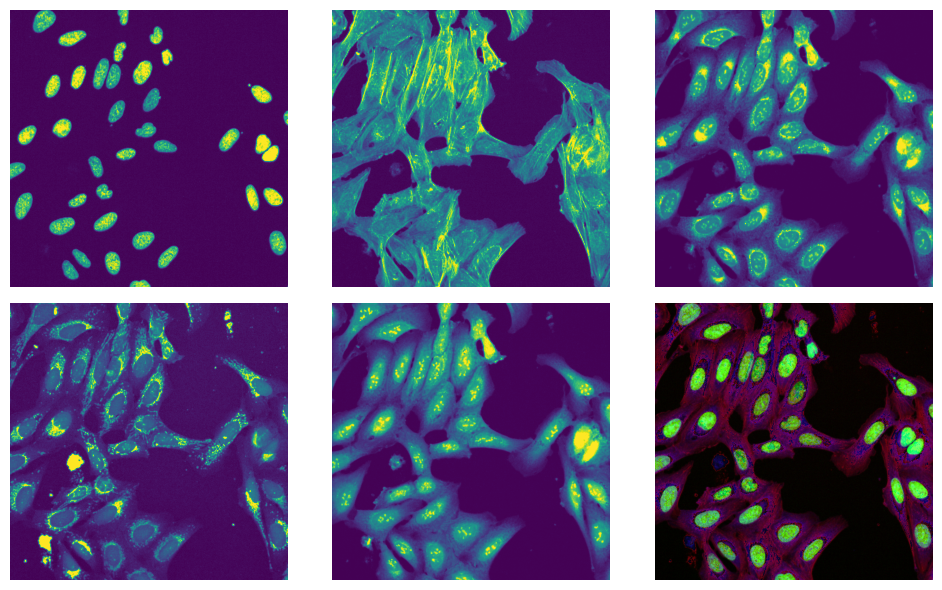

In [58]:
plot_example(dt[0]);

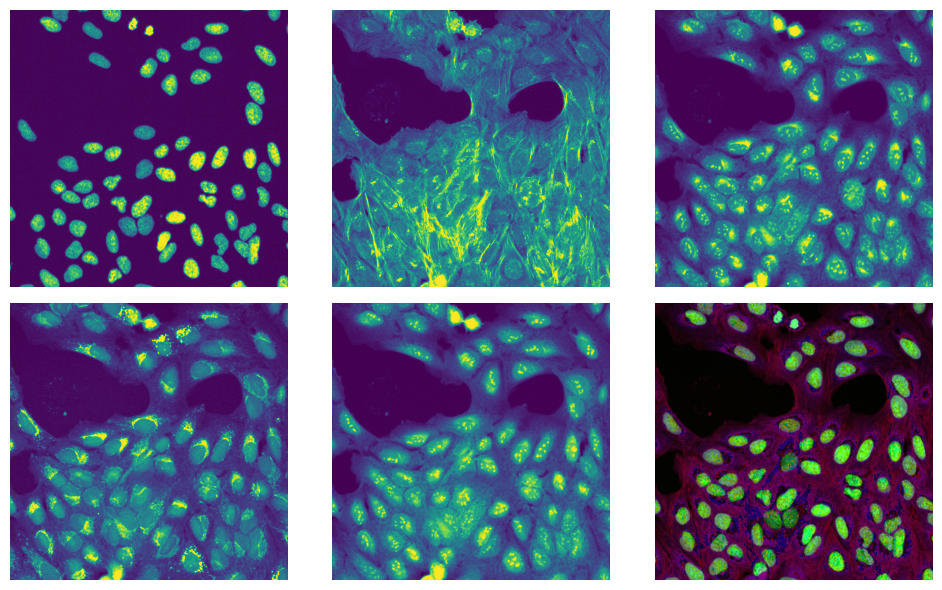

In [59]:
plot_example(dt[64]);

In [99]:
config = ViTMAEConfig(
    image_size=512,
    patch_size=16,
    num_channels=5,
    mask_ratio=0.75,
    norm_pix_loss=True,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    decoder_num_attention_heads=8,
    decoder_hidden_size=512,
    decoder_num_hidden_layers=4,
    decoder_intermediate_size=2048,
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
)

In [100]:
model = ViTMAEForPreTraining(config)

In [101]:
model

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(5, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bi

In [63]:
dl = module.val_dataloader(batch_size=4)

In [64]:
b = next(iter(dl))

In [77]:
b.shape

torch.Size([4, 5, 512, 512])

In [134]:
model.patchify(b).shape

torch.Size([4, 1024, 1280])

In [147]:
res = model.forward(b)

In [148]:
res

ViTMAEForPreTrainingOutput(loss=tensor(1.2050, grad_fn=<DivBackward0>), logits=tensor([[[-0.1490,  0.4964, -0.3957,  ..., -0.2178,  0.4146, -0.4306],
         [ 0.1000,  0.6097, -0.5018,  ..., -0.2231,  0.0774, -0.5586],
         [-0.2847,  0.4259, -0.3306,  ..., -0.1532,  0.4713, -0.5329],
         ...,
         [ 0.0973,  0.5339, -0.6020,  ..., -0.3289,  0.4955, -0.3731],
         [ 0.3784,  0.0986, -0.3284,  ..., -0.5242, -0.2421, -0.4075],
         [ 0.3586,  0.0448, -0.3744,  ..., -0.4558, -0.1658, -0.3839]],

        [[ 0.1001,  0.5793, -0.4936,  ..., -0.1181,  0.1570, -0.4988],
         [ 0.0482,  0.4903, -0.4771,  ..., -0.1797,  0.3801, -0.3605],
         [ 0.0655,  0.6694, -0.4377,  ..., -0.2691,  0.0341, -0.6375],
         ...,
         [ 0.4675,  0.1745, -0.2756,  ..., -0.6106, -0.2885, -0.3571],
         [ 0.3804,  0.0954, -0.3218,  ..., -0.5228, -0.2502, -0.4037],
         [ 0.3607,  0.0417, -0.3677,  ..., -0.4542, -0.1744, -0.3802]],

        [[ 0.0919,  0.5881, -0.4873, 

In [141]:
predicted_images = model.unpatchify(res.logits)

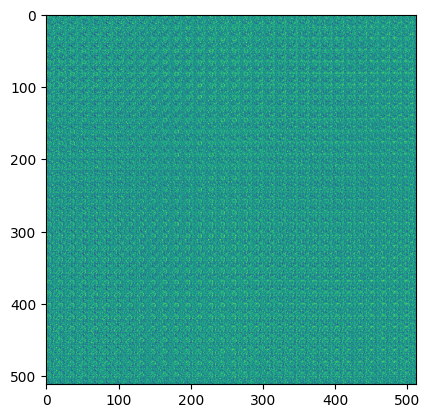

In [145]:
plt.imshow(predicted_images[0, 0].detach().numpy())

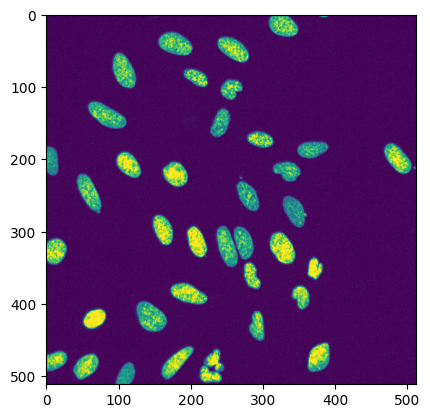

In [146]:
plt.imshow(b[0, 0].detach().numpy())

In [120]:
res2 = model.vit.forward(b)

In [123]:
res2

ViTMAEModelOutput(last_hidden_state=tensor([[[-0.9129,  0.1795,  1.8769,  ...,  0.2141, -2.0225,  2.2234],
         [-0.3982, -0.3086,  0.2332,  ..., -0.1909, -0.3006,  2.3779],
         [-0.5009, -0.2678,  0.7774,  ..., -0.2625, -1.4036,  2.8213],
         ...,
         [ 0.0441, -0.6050,  0.8915,  ...,  0.2421,  0.0300,  2.3827],
         [-0.7210, -0.9603,  0.3414,  ..., -0.0444, -1.1549,  2.8326],
         [ 0.0899,  0.1232,  1.0043,  ..., -0.5704, -0.5075,  2.6828]],

        [[-0.8049,  0.1136,  1.7544,  ...,  0.1049, -2.0348,  2.3367],
         [ 0.6837, -1.1833,  0.6290,  ..., -0.0365, -0.3241,  3.1562],
         [-0.3283, -0.2029,  0.1426,  ...,  0.5026, -1.0708,  2.6350],
         ...,
         [ 0.9290, -0.0477,  2.5215,  ..., -0.1107, -1.1113,  3.1014],
         [-0.0743, -1.1352,  1.5459,  ..., -0.0577, -0.3441,  2.7616],
         [ 0.2837, -0.0622,  0.6703,  ..., -0.3402, -0.3264,  3.3815]],

        [[-0.4873,  0.1361,  1.4704,  ...,  0.0301, -2.1645,  2.4606],
         

In [127]:
res.logits.shape

torch.Size([4, 1024, 1280])